In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# ! pip uninstall tensorflow


In [3]:
# ! pip install tensorflow==2.11

# 데이터 로드

In [4]:
path = '..\아림경영\데이터\기업별 뉴스'

In [5]:
# path_재무 = '.\데이터\기업별 재무제표\재무제표 원본\재무제표'

In [6]:
import os
file_list = os.listdir(path)
len(file_list)

140

In [7]:
file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    # else:
    #     for k in range(len(file)-1,0,-1):
    #         if file[k]=='.':
    #             file_name.append(file[:k])
    #             break

In [8]:
file_name[:5]

['CMG제약', 'HLB생명과학', 'JW생명과학', 'JW신약', 'JW중외제약']

In [9]:
df1 = []
for 기업 in file_name:
    df =pd.read_excel(f"../아림경영/데이터/기업별 뉴스/{기업}.xlsx",sheet_name='#02 Documents')#,header=0,skiprows=[1,2])
    # df = df[['Unnamed: 2','20221231','20211231','20201231','20191231','20181231']]
    df = pd.DataFrame(df)
    df1.append(df)
len(df1)

140

In [44]:
# df1[0]

In [11]:
df2 =[]
for df in df1:
    df = df[['date','title','polarity.label']]
    df['polarity.label'] = df['polarity.label'].replace(-1,2)
    # dupli = df[df.duplicated()]
    df.drop_duplicates(subset=['title'], inplace=True)
    df2.append(df)
    # duplicate_list.append(dupli)

In [12]:
len(df2)

140

In [13]:
df2[49].head(2)

,date,title,polarity.label
0,2023-05-24,[취재 일지]세계는 여전히 ‘건기식’ 열풍… 경쟁력 높이려면 식약처 기준 완화돼야,NaN
1,2023-05-23,"어린이 프로바이오틱스, 유산균도 가격도 천차만별…따져보고 사야",NaN


# 훈련-테스트

In [14]:
len(df2[0])

60

In [15]:
# df2[0][   df2[0]['polarity.label'].notna()    ]

In [16]:
train = []
test  = []
for df in df2:
    tmp_train = df[df['polarity.label'].notna()]
    tmp_test = df[df['polarity.label'].isna()]
    train.append(tmp_train)
    test.append(tmp_test)

In [17]:
len(train), len(test)

(140, 140)

In [18]:
# train

In [19]:
mecab = mecab.MeCab()

In [20]:
train1 =[]
for df in train:
    df['tokenized'] = df['title'].apply(mecab.morphs)
    train1.append(df)

In [21]:
train1[0].head(2)

,date,title,polarity.label,tokenized
2,2023-05-04,"한독, 당뇨 치료·항염증제 이을 새 성장 동력은?",1.0,"[한독, ,, 당뇨, 치료, ·, 항염증제, 이, 을, 새, 성장, 동력, 은, ?]"
3,2023-04-24,"CMG제약 '차앤맘', 2023 SCWC 사랑의 바자회 참가",1.0,"[CMG, 제약, ', 차, 앤, 맘, ',, 2023, SCWC, 사랑, 의, 바..."


In [22]:
train_df = pd.concat(train1, axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 2 to 408
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            18038 non-null  object 
 1   title           18038 non-null  object 
 2   polarity.label  18038 non-null  float64
 3   tokenized       18038 non-null  object 
dtypes: float64(1), object(3)
memory usage: 704.6+ KB


In [23]:
X = train_df['tokenized']
y = train_df['polarity.label']

In [24]:
y[:2]

2    1.0
3    1.0
Name: polarity.label, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [26]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((14430,), (3608,), (14430,), (3608,))

In [27]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 31.247%
긍정 = 59.91%
부정 = 8.843%


In [28]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 31.236%
긍정 = 59.922%
부정 = 8.841%


# 토크나이즈

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[3, 15, 3001, 16, 8, 39, 13, 4, 3322, 22, 844, 115, 230, 79, 7409, 83, 118, 5465, 7410, 16, 774, 1, 8, 13, 315, 670], [173, 8, 1, 2, 65, 3002, 2, 509, 9, 9, 9, 162, 60, 20, 5466, 3002], [3, 26, 12, 4, 127, 684, 1, 103, 229, 6, 214, 19, 61, 9, 9, 9, 127, 9, 783, 535, 28, 50, 116], [3, 24, 33, 149, 40, 119, 20, 4, 6, 276, 394, 1, 119, 1, 7411, 11, 42, 1480, 483, 387, 175, 90, 28], [417, 76, 3323, 799, 15, 1180, 426, 210, 16, 6, 2019, 20, 29]]
[[3, 26, 12, 4, 450, 1, 754, 21, 1879, 2676, 67, 222, 39, 1370, 167, 6, 116], [104, 2765, 88, 1, 3292, 43, 2550, 9, 646, 480, 3480], [12119, 821, 76, 95, 2266, 1365, 9, 436, 2, 5, 176, 43, 2, 5357, 2, 7], [14, 256, 313, 1043, 49, 103, 5, 104, 14, 68, 3047, 1, 23, 68, 22, 118], [618, 804, 1, 1486, 2374, 2742, 1476, 14, 1, 9946, 338, 886]]


In [30]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

12765


# 패딩

In [31]:
X_train[:2]

475    [[, ‘, 생생, ’, 제약, -, 바이오, ], 그때, 는, 맞, 고, 지금, ...
599    [보령, 제약, ,, ', 백신, 휴가, ', 도입, ·, ·, ·, 최대, 4, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 40
본문의 평균 길이 : 15.506237006237006


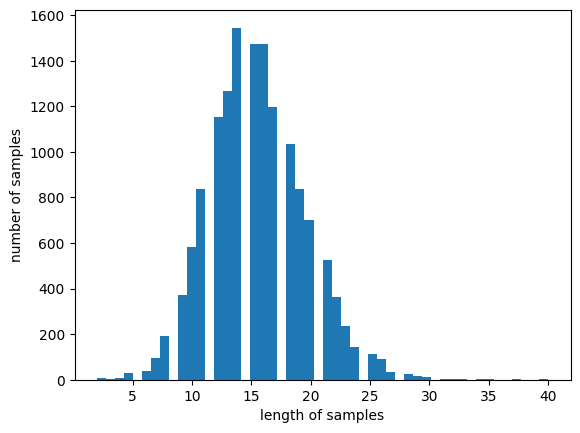

In [32]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
max_len = 76

In [34]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [35]:
X_train_encoded.shape

(14430, 76)

In [36]:
X_test_encoded.shape

(3608, 76)

In [37]:
X_train_encoded[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    3,   15, 3001,   16,    8,
          39,   13,    4, 3322,   22,  844,  115,  230,   79, 7409,   83,
         118, 5465, 7410,   16,  774,    1,    8,   13,  315,  670]])

In [38]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델

In [42]:
y_train.shape

(14430, 3)

In [40]:
model = load_model('../아림경영/NLP/NLP/best_model.h5')
model

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('../아림경영/NLP/NLP/best_model.h55', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)
history = model.fit(X_train_encoded, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "C:\AI\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\AI\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\AI\pythonProject\venv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\AI\pythonProject\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\AI\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\AI\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\AI\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "C:\AI\pythonProject\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\AI\pythonProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASIA\AppData\Local\Temp\ipykernel_8752\107533149.py", line 3, in <module>
      history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\AI\pythonProject\venv\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_1/embedding_1/embedding_lookup'
indices[10,71] = 11526 is not in [0, 8942)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_2067]

<pre>
Graph execution error:
    # uninstall tensorflow 2.12
    $ pip uninstall tensorflow

    # reinstall tensorflow 2.11
    $ pip install tensorflow==2.11